In [1]:
%matplotlib notebook

In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from scipy.interpolate import interp1d
import scipy.integrate as integrate
from scipy.interpolate import splev, splrep
from scipy.interpolate import UnivariateSpline
import numpy.ma as ma
import scipy.optimize
from matplotlib import rc

import os

In [3]:
data = np.genfromtxt('HC_Cavendish_CrCl2pym-Ag_2to60K.dat',skip_header=15,delimiter=',')
data = data[np.argsort(data[:, 7])]
T = data[:,7] #in Kelvin 
sHC = data[:,9] #in µJ/K
err = data[:,10] #in µJ/K

start = np.argmax(T>0)
stop = np.argmax(T>15)
restart = np.argmax(T>27)

T1 = data[start:stop,7]
T2 = data[restart:,7]
T3 = np.concatenate((T1,T2))

ten = np.argmax(T>10)
twelve = np.argmax(T>12)
thirty = np.argmax(T>30)

sHC1 = data[start:stop,9]
sHC2 = data[restart:,9]
sHC3 = np.concatenate((sHC1,sHC2))

sHC4 = sHC3[twelve:]

err1 = data[start:stop,10]
err2 = data[restart:,10]
err3 = np.concatenate((err1,err2))

def Ag_HC_fit(T_input):
    data2 = np.loadtxt('NIST_Ag_heat_capacity.dat')
    temp = data2[:,0]
    Cpm = (data2[:,1])*1e6
    fit = interp1d(temp,Cpm, kind='cubic')
    Cpm_fitted = fit(T_input)
    return Cpm_fitted

def Ag_HC_fit_molar(T_input):
    data2 = np.loadtxt('NIST_Ag_heat_capacity.dat')
    temp2 = data2[:,0]
    Cpm2 = (data2[:,1])*1e6
    fit2 = interp1d(temp2,Cpm2, kind='cubic')
    Cpm_fitted2 = fit2(T_input)
    Cr = (sHC/Cr_moles)-Cpm_fitted2
    return Cr

def Ag_HC_fit_molar_sub(T_input):
    data3 = np.loadtxt('NIST_Ag_heat_capacity.dat')
    temp3 = data3[:,0]
    Cpm3 = (data3[:,1])*1e6
    fit3 = interp1d(temp3,Cpm3, kind='cubic')
    Cpm_fitted3 = fit3(T_input)
    Cr1 = (sHC3/Cr_moles)-Cpm_fitted3
    return Cr1

def Ag_HC_fit_molar_subtraction(T_1, T_2):
    data4 = np.loadtxt('NIST_Ag_heat_capacity.dat')
    temp4 = data4[:,0]
    Cpm4 = (data4[:,1])*1e6
    fit4 = interp1d(temp4,Cpm4, kind='cubic')
    Cpm_fitted4 = fit4(T_1)
    Cpm_fitted5 = fit4(T_2)
    Cr = (sHC/Cr_moles)-Cpm_fitted4
    Cr1 = (sHC3/Cr_moles)-Cpm_fitted5
    data = data[np.argsort(data[:, 7])]
    fit5 = interp1d(T_2,Cr1, kind='cubic')
    subtraction = fit5(T_1)
    s = Cr - subtraction
    return s

In [4]:
Cr_mass = 4.2*1e-3*50.7/(50.2+50.7) #g
Cr_moles = Cr_mass/203 #mol, molar mass of CrCl2pym = 122.9 + 81.1 = 203.0 g/mol

Ag_mass = 4.2*1e-3*50.2/(50.2+50.7) #g
Ag_moles = Ag_mass/107.9 #mol, molar mass of silver = 107.9 g/mol

In [5]:
def Cp(T, m, c): #einstein debye fit
	return m*T + c

def C(T, A): #debye fit
	return A*(T**3)

In [6]:
T4 = T3[ten:thirty]

Cpm_fitted4 = Ag_HC_fit(T)
Cpm_fitted5 = Ag_HC_fit(T3)
Cpm_fitted6 = Ag_HC_fit(T4)

ten = np.argmax(T>10)
twelve = np.argmax(T>12)
fifteen = np.argmax(T>15)
twentyseven = np.argmax(T>27)
thirty = np.argmax(T>30)

Cr = sHC-(Cpm_fitted4*Ag_moles)
Cr = Cr/Cr_moles
Cr1 = sHC3-(Cpm_fitted5*Ag_moles)
Cr1 = Cr1/Cr_moles
Cr3 = Cr1[ten:thirty]

popt, pcov = scipy.optimize.curve_fit(Cp, T4, Cr3)

subtraction2 = Cp(T, *popt)

fit5 = np.poly1d(np.polyfit(T3, Cr1, 5))
fit6 = interp1d(T3, Cr1, kind='linear')
subtraction = fit5(T)
subtraction3 = fit6(T)
s = (Cr/T) - (subtraction2/T)
s = s*1e-6

I = np.cumsum(s[fifteen:twentyseven])
Ismooth = np.poly1d(np.polyfit(T[fifteen:twentyseven],I, 3))

<IPython.core.display.Javascript object>


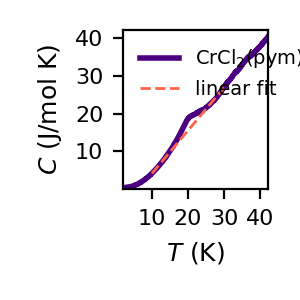

In [7]:
fig = plt.figure(4, figsize=(1.5, 1.5))
ax1 = plt.subplot()
ax1.plot(T,(Cr)*1e-6, label='CrCl$_2$(pym)',  color="indigo", linewidth=2)
ax1.plot(T[ten:thirty],(subtraction2[ten:thirty])*1e-6, label='linear fit',c="tomato", linestyle='--', linewidth=1)

ax1.set_xlabel('$T$ (K)', fontsize=9)
ax1.set_ylabel('$C$ (J/mol K)', fontsize=9)
ax1.set_xlim((2,42))
ax1.set_ylim((0,42))
ax1.set_xticks(ticks=[10,20,30,40])
ax1.set_yticks(ticks=[10,20,30,40])
ax1.tick_params(axis='both', labelsize=8)
ax1.legend(frameon=False, loc=2, fontsize=7)
plt.rcParams['pdf.fonttype'] = 3
#plt.savefig('HC_plot_CrCl2pym.pdf',bbox_inches='tight', transparent=True)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


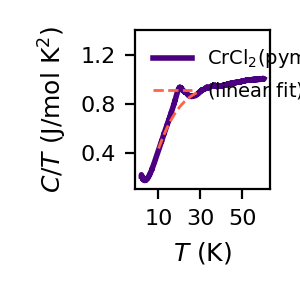

In [8]:
fig = plt.figure(7, figsize=(1.5, 1.5))
ax1 = plt.subplot()

ax1.plot(T,(Cr)*1e-6/T, label='CrCl$_2$(pym)',  color="indigo", linewidth=2)

ax1.plot(T[ten:thirty],(subtraction[ten:thirty])*1e-6/T[ten:thirty], label='(linear fit)/$T$',c="tomato", linestyle='--', linewidth=1)

ax1.set_xlabel('$T$ (K)', fontsize=9)
ax1.set_ylabel('$C/T$ (J/mol K$^2$)', fontsize=9)
#ax1.set_xlim((2,42))
ax1.set_ylim((0.1,1.4))
ax1.set_xticks(ticks=[10,30,50])
ax1.set_yticks(ticks=[0.4,0.8,1.2])
ax1.tick_params(axis='both', labelsize=8)
ax1.legend(frameon=False, loc=2, fontsize=7)
plt.rcParams['pdf.fonttype'] = 3
#plt.savefig('HC_over_T_plot_CrCl2pym.pdf',bbox_inches='tight', transparent=True)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


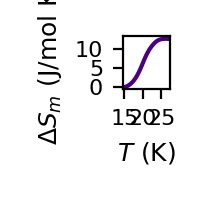

In [9]:
fig = plt.figure(8, figsize=(1, 1))
ax1 = plt.subplot()

Irebin = (I[0:-3:3]+I[1:-3:3]+I[2:-3:3])/3
Trebin = T[fifteen:twentyseven]
Trebin = Trebin[0:180:3]
Trebin = Trebin[0:59]
ax1.plot(Trebin,Irebin,color="indigo",label="$\Delta S_m$")
ax1.set_xlabel('$T$ (K)', fontsize=9)
ax1.set_ylabel('$\Delta S_m$ (J/mol K)', fontsize=9)
#ax1.set_xlim((2,42))\
#ax1.set_ylim((0,42))
ax1.set_xticks(ticks=[15,20,25])
ax1.set_yticks(ticks=[0,5,10])
ax1.tick_params(axis='both', labelsize=8)
#ax1.legend(frameon=False, loc='lower right', fontsize=7, bbox_to_anchor=(1.1, -0.01))
plt.rcParams['pdf.fonttype'] = 3
#plt.savefig('HC_over_T_int_CrCl2pym.pdf',bbox_inches='tight', transparent=True)
plt.tight_layout()
plt.show()